Tubeの場所と予測を保存

In [1]:
import ast
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
from glob import glob
from multiprocessing import Pool

In [2]:
df = pd.read_csv('/data/df_train2.csv')
df_anot = pd.read_csv('/data/train_annotations.csv')
df_bifurcation = pd.read_csv('/data/additional/RANZCR_CLiP_tracheal_bifurcation.csv')
df_cvc = pd.read_csv('/data/additional/cvc_malposition_categories.csv')

In [8]:
df_anot[df_anot.label.str.contains('CVC')].StudyInstanceUID.unique()

array(['1.2.826.0.1.3680043.8.498.12616281126973421762775197134528405307',
       '1.2.826.0.1.3680043.8.498.72921907356394389969069434057117070831',
       '1.2.826.0.1.3680043.8.498.11697104485452001927211929869950495038',
       ...,
       '1.2.826.0.1.3680043.8.498.66774579023475418162888677784385387033',
       '1.2.826.0.1.3680043.8.498.18560506324214035535556371154113749001',
       '1.2.826.0.1.3680043.8.498.98119637144473510638072955005700194204'],
      dtype=object)

In [9]:
df[df.StudyInstanceUID.isin(df_anot[df_anot.label.str.contains('CVC')].StudyInstanceUID.unique())]

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID,fold,img_path,cv
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5,3,/data/train512/1.2.826.0.1.3680043.8.498.23819...,3
6,1.2.826.0.1.3680043.8.498.23133310896792275593...,0,0,0,0,0,0,0,0,1,1,0,f6147af3f,4,/data/train512/1.2.826.0.1.3680043.8.498.23133...,4
10,1.2.826.0.1.3680043.8.498.21553435248897151659...,0,0,1,1,0,0,1,0,0,1,0,00f261590,4,/data/train512/1.2.826.0.1.3680043.8.498.21553...,4
11,1.2.826.0.1.3680043.8.498.84472839875948876829...,0,0,0,0,0,0,0,0,0,1,0,2cf8f57b2,1,/data/train512/1.2.826.0.1.3680043.8.498.84472...,1
17,1.2.826.0.1.3680043.8.498.58764130686095794423...,0,0,0,0,0,0,0,0,0,1,0,d1a2e61aa,2,/data/train512/1.2.826.0.1.3680043.8.498.58764...,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30063,1.2.826.0.1.3680043.8.498.10971556774256804583...,0,0,0,0,0,0,0,0,0,1,0,bdc004586,4,/data/train512/1.2.826.0.1.3680043.8.498.10971...,4
30071,1.2.826.0.1.3680043.8.498.53525361705976355115...,0,0,0,0,0,0,0,0,0,1,0,d81b38be3,0,/data/train512/1.2.826.0.1.3680043.8.498.53525...,0
30079,1.2.826.0.1.3680043.8.498.46510939987173529969...,0,0,0,0,0,0,0,0,0,1,0,7192404d8,4,/data/train512/1.2.826.0.1.3680043.8.498.46510...,4
30080,1.2.826.0.1.3680043.8.498.43173270582850645437...,0,0,1,0,0,1,0,1,0,1,0,d4d1b066d,2,/data/train512/1.2.826.0.1.3680043.8.498.43173...,2


In [3]:
import math
def sigmoid(a):
    s = 1 / (1 + math.e**-a)
    return s

In [4]:
oof_800 = sigmoid(np.load('/workspace/output/exp024_test800_2/oof/oof.npy'))
oof_864 = sigmoid(np.load('/workspace/output/exp024_test864_2/oof/oof.npy'))
oof = (oof_800 + oof_864) / 2

In [5]:
df_oof = df.copy()
df_oof.loc[:, df.columns[1:12]] = oof
df_oof.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID,fold,img_path,cv
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0.001345,0.003047,0.003735,0.016243,0.106178,0.009688,0.798720,0.176817,0.059686,0.062804,0.000457,ec89415d1,3,/data/train512/1.2.826.0.1.3680043.8.498.26697...,3
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0.001430,0.076165,0.936450,0.241422,0.055716,0.776671,0.066677,0.027979,0.091682,0.870807,0.003910,bf4c6da3c,3,/data/train512/1.2.826.0.1.3680043.8.498.46302...,3
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0.000007,0.000042,0.000059,0.000032,0.000043,0.000065,0.000050,0.014588,0.572776,0.412521,0.000046,3fc1c97e5,3,/data/train512/1.2.826.0.1.3680043.8.498.23819...,3
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0.000134,0.000346,0.001272,0.002425,0.001956,0.000898,0.000724,0.978339,0.024767,0.021996,0.000234,c31019814,0,/data/train512/1.2.826.0.1.3680043.8.498.68286...,0
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0.000015,0.000637,0.014400,0.000177,0.000206,0.000502,0.000376,0.000678,0.002632,0.998719,0.000002,207685cd1,0,/data/train512/1.2.826.0.1.3680043.8.498.10050...,0


In [6]:
lung_path = glob('/data/additional/train_lung_masks/train_lung_masks/*jpg')

In [7]:
cvc_cols = ["CVC - Abnormal", "CVC - Borderline", "CVC - Normal"]

In [8]:
df["is_cvc"] = df[cvc_cols].max(1)

In [9]:
df["CVC - Abnormal"].value_counts()

0    26888
1     3195
Name: CVC - Abnormal, dtype: int64

In [10]:
df["CVC - Borderline"].value_counts()

0    21623
1     8460
Name: CVC - Borderline, dtype: int64

In [11]:
df["CVC - Normal"].value_counts()

1    21324
0     8759
Name: CVC - Normal, dtype: int64

In [12]:
mask = cv2.imread('/data/additional/train_lung_masks/train_lung_masks/1.2.826.0.1.3680043.8.498.10000428974990117276582711948006105617.jpg')

In [13]:
mask.max()

255

CVCの先端を自分で見つけ出すことは可能かな？

必要なところだけをピックアップ

# 手動ラベリングとか

In [25]:
def plot_xray(StudyInstanceUID, label, data):
    """
    intubation as green
    bifurcation as red
    """
    pred = df_oof[df_oof.StudyInstanceUID == StudyInstanceUID]
    Normal = pred["CVC - Normal"].values[0]
    Borderline = pred["CVC - Borderline"].values[0]
    Abnormal = pred["CVC - Abnormal"].values[0]
    
    
    img = cv2.imread('/data/train/'+StudyInstanceUID+'.jpg')
    mask = cv2.imread('/data/additional/train_lung_masks/train_lung_masks/'+StudyInstanceUID+'.jpg')
    mask = cv2.resize(mask, (1280, 1280))
    mask = (mask < 128)*255
    
    original_h, original_w, _ = img.shape
    img = cv2.resize(img, (1280, 1280))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
    img = clahe.apply(img[:,:,0])
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    img[:,:,2] = img[:,:,2]*0.7+mask[:,:,2]*0.3
    
    intubation = ast.literal_eval(data)
#     intubation = ast.literal_eval(df_anot.loc[(df_anot.StudyInstanceUID==StudyInstanceUID) & (df_anot.label==label),'data'].values[0])
    cvc_seg_mask = np.zeros((original_h, original_w, 3)).astype(np.uint8)
    
    for i in range(len(intubation)):
        pos_y, pos_x = intubation[i]
        pos_x = (pos_x * 1280) / original_h
        pos_y = (pos_y * 1280) / original_w
        img = cv2.circle(img, (int(pos_y), int(pos_x)), 5, (0,255,0), 5)
        img = cv2.putText(img, str(i), (int(pos_y-10), int(pos_x-10)), cv2.FONT_HERSHEY_PLAIN, fontScale=2, color=(255, 0, 0), thickness=2)
        img = cv2.putText(img, label[5:], (50, 1100), cv2.FONT_HERSHEY_PLAIN, fontScale=10, color=(255, 0, 0), thickness=8)
        img = cv2.putText(img, f"Normal: {Normal:.4f}", (50, 1150), cv2.FONT_HERSHEY_PLAIN, fontScale=4, color=(255, 0, 0), thickness=4)
        img = cv2.putText(img, f"Borderline: {Borderline:.4f}", (50, 1200), cv2.FONT_HERSHEY_PLAIN, fontScale=4, color=(255, 0, 0), thickness=4)
        img = cv2.putText(img, f"Abnormal: {Abnormal:.4f}", (50, 1250), cv2.FONT_HERSHEY_PLAIN, fontScale=4, color=(255, 0, 0), thickness=4)
        
        if i+1 < len(intubation):
            pos_y, pos_x = intubation[i]
            pos_y_n, pos_x_n = intubation[i+1]
            cvc_seg_mask = cv2.line(cvc_seg_mask, (pos_y, pos_x), (pos_y_n, pos_x_n), (255, 255, 255), 5)
            
    img = cv2.circle(img, (img.shape[1]//2, img.shape[0]//2), 10, (0,0,255), 10)
    plt.figure(figsize=(12,20))
    plt.title(f'label: {label}, Normal: {Normal:.4f}, Borderline: {Borderline:.4f}, Abnormal: {Abnormal:.4f}')
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(cvc_seg_mask)

    
def save_cvc_seg_check(StudyInstanceUID, label, data, patient_id, num):
    """
    intubation as green
    bifurcation as red
    """
    pred = df_oof[df_oof.StudyInstanceUID == StudyInstanceUID]
    Normal = pred["CVC - Normal"].values[0]
    Borderline = pred["CVC - Borderline"].values[0]
    Abnormal = pred["CVC - Abnormal"].values[0]
    
    img = cv2.imread('/data/train/'+StudyInstanceUID+'.jpg')
    original_h, original_w, _ = img.shape
    img = cv2.resize(img, (1280, 1280))

    cvc_seg_mask = np.zeros((original_h, original_w, 3)).astype(np.uint8)
    
    rows = df_anot[df_anot.StudyInstanceUID == StudyInstanceUID]
    
    for r in range(len(rows)):
        data_r = rows.data.iloc[r]
        intubation = ast.literal_eval(data_r)
        for i in range(len(intubation)):
            
            pos_y, pos_x = intubation[i]
            pos_x = (pos_x * 1280) / original_h
            pos_y = (pos_y * 1280) / original_w
            img = cv2.circle(img, (int(pos_y), int(pos_x)), 5, (0,255,0), 5)
            img = cv2.putText(img, str(i), (int(pos_y-10), int(pos_x-10)), cv2.FONT_HERSHEY_PLAIN, fontScale=2, color=(255, 0, 0), thickness=2)
            img = cv2.putText(img, label[5:], (50, 1100), cv2.FONT_HERSHEY_PLAIN, fontScale=10, color=(255, 0, 0), thickness=8)
            img = cv2.putText(img, f"Normal: {Normal:.4f}", (50, 1150), cv2.FONT_HERSHEY_PLAIN, fontScale=4, color=(255, 0, 0), thickness=4)
            img = cv2.putText(img, f"Borderline: {Borderline:.4f}", (50, 1200), cv2.FONT_HERSHEY_PLAIN, fontScale=4, color=(255, 0, 0), thickness=4)
            img = cv2.putText(img, f"Abnormal: {Abnormal:.4f}", (50, 1250), cv2.FONT_HERSHEY_PLAIN, fontScale=4, color=(255, 0, 0), thickness=4)
            
            if i+1 < len(intubation):
                pos_y, pos_x = intubation[i]
                pos_y_n, pos_x_n = intubation[i+1]
                cvc_seg_mask = cv2.line(cvc_seg_mask, (pos_y, pos_x), (pos_y_n, pos_x_n), (255, 255, 255), 10)
            
    cvc_seg_mask = cv2.resize(cvc_seg_mask, (800, 800))
    
    ax = plt.figure(figsize=(20,10))
    plt.title(f'label: {label}, Normal: {Normal:.4f}, Borderline: {Borderline:.4f}, Abnormal: {Abnormal:.4f}')
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(cvc_seg_mask)
    plt.tight_layout()
    plt.savefig(f'/data/eda_plot/cvc_seg_line_check/{StudyInstanceUID}.jpg')
    plt.close()
    del ax
#     print(f'/data/additional/cvc_line_seg/{StudyInstanceUID}.jpg')
    
    
    
# def save_xray(StudyInstanceUID, label, data, patient_id, num):
#     """
#     intubation as green
#     bifurcation as red
#     """
#     pred = df_oof[df_oof.StudyInstanceUID == StudyInstanceUID]
#     Normal = pred["CVC - Normal"].values[0]
#     Borderline = pred["CVC - Borderline"].values[0]
#     Abnormal = pred["CVC - Abnormal"].values[0]
    
#     img = cv2.imread('/data/train/'+StudyInstanceUID+'.jpg')
#     mask = cv2.imread('/data/additional/train_lung_masks/train_lung_masks/'+StudyInstanceUID+'.jpg')
#     mask = cv2.resize(mask, (1280, 1280))
#     mask = (mask < 128)*255
    
#     original_h, original_w, _ = img.shape
#     img = cv2.resize(img, (1280, 1280))
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
#     img = clahe.apply(img[:,:,0])
#     img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
#     img[:,:,2] = img[:,:,2]*0.7+mask[:,:,2]*0.3
    
# #     intubation = ast.literal_eval(df_anot.loc[(df_anot.StudyInstanceUID==StudyInstanceUID) & (df_anot.label==label),'data'].values[0])
#     intubation = ast.literal_eval(data)
#     for i in range(len(intubation)):
#         pos_y, pos_x = intubation[i]
#         pos_x = (pos_x * 1280) / original_h
#         pos_y = (pos_y * 1280) / original_w
#         img = cv2.circle(img, (int(pos_y), int(pos_x)), 5, (0,255,0), 5)
#         img = cv2.putText(img, str(i), (int(pos_y-10), int(pos_x-10)), cv2.FONT_HERSHEY_PLAIN, fontScale=2, color=(255, 0, 0), thickness=2)
#         img = cv2.putText(img, label[5:], (50, 1100), cv2.FONT_HERSHEY_PLAIN, fontScale=10, color=(255, 0, 0), thickness=8)
#         img = cv2.putText(img, f"Normal: {Normal:.4f}", (50, 1150), cv2.FONT_HERSHEY_PLAIN, fontScale=4, color=(255, 0, 0), thickness=4)
#         img = cv2.putText(img, f"Borderline: {Borderline:.4f}", (50, 1200), cv2.FONT_HERSHEY_PLAIN, fontScale=4, color=(255, 0, 0), thickness=4)
#         img = cv2.putText(img, f"Abnormal: {Abnormal:.4f}", (50, 1250), cv2.FONT_HERSHEY_PLAIN, fontScale=4, color=(255, 0, 0), thickness=4)
#     img = cv2.circle(img, (img.shape[1]//2, img.shape[0]//2), 10, (0,0,255), 10)
#     ax = plt.figure(figsize=(12,12))
#     plt.title(f'label: {label}, Normal: {Normal:.4f}, Borderline: {Borderline:.4f}, Abnormal: {Abnormal:.4f}')
#     plt.imshow(img)
#     plt.savefig(f"/data/eda_plot/cvc_clahe_tube/{patient_id}_{StudyInstanceUID}_{label}_{num}.jpeg")
#     plt.clf()
#     plt.close()
#     del ax
#     gc.collect()

In [26]:
df_cvc = df[df.is_cvc == 1]

In [27]:
cvc_study_id = df_cvc.StudyInstanceUID.values

In [28]:
df_anot_cvc = df_anot[df_anot.label.isin(cvc_cols)]

In [29]:
df_anot_cvc_no_dup = df_anot_cvc.groupby('StudyInstanceUID').first().reset_index()

In [30]:
# ind = i
# row = df_anot_cvc[df_anot_cvc.StudyInstanceUID == "1.2.826.0.1.3680043.8.498.56123128911983663680403594219494298539"]
# plot_xray(row.StudyInstanceUID, row.label)

In [31]:
df_anot_cvc

,StudyInstanceUID,label,data
0,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1487, 1279], [1477, 1168], [1472, 1052], [14..."
1,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1328, 7], [1347, 101], [1383, 193], [1400, 2..."
2,1.2.826.0.1.3680043.8.498.72921907356394389969...,CVC - Borderline,"[[801, 1207], [812, 1112], [823, 1023], [842, ..."
3,1.2.826.0.1.3680043.8.498.11697104485452001927...,CVC - Normal,"[[1366, 961], [1411, 861], [1453, 751], [1508,..."
5,1.2.826.0.1.3680043.8.498.87704688663091069148...,CVC - Normal,"[[906, 604], [1103, 578], [1242, 607], [1459, ..."
...,...,...,...
17993,1.2.826.0.1.3680043.8.498.88885675487819792225...,CVC - Normal,"[[1384, 1098], [1480, 899], [1554, 774], [1630..."
17995,1.2.826.0.1.3680043.8.498.18590666552942008211...,CVC - Normal,"[[1250, 1105], [1247, 1031], [1248, 970], [126..."
17996,1.2.826.0.1.3680043.8.498.66774579023475418162...,CVC - Normal,"[[1379, 1402], [1389, 1233], [1386, 1137], [13..."
17997,1.2.826.0.1.3680043.8.498.18560506324214035535...,CVC - Normal,"[[1302, 1543], [1308, 1488], [1317, 1355], [13..."


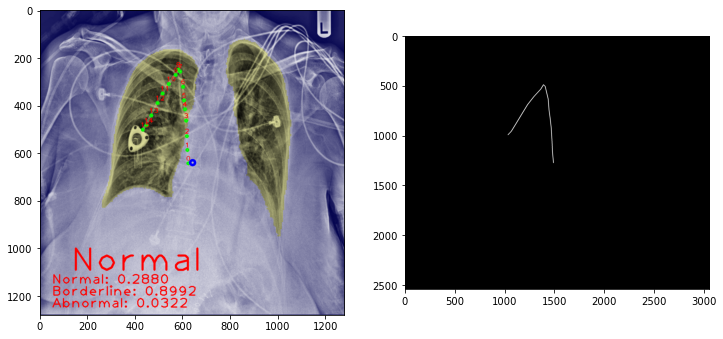

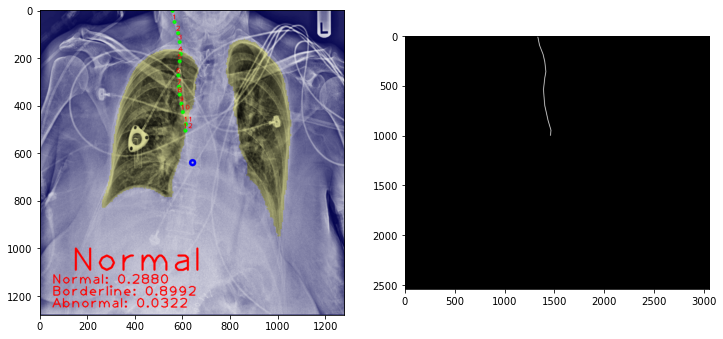

In [32]:
for i in range(2):
    ind = i
    row = df_anot_cvc.iloc[ind]
    plot_xray(row.StudyInstanceUID, row.label, row.data)

In [33]:
def save_xray_multi(ind):
    row = df_anot_cvc_no_dup.iloc[ind]
    patient_id = df[df.StudyInstanceUID == row.StudyInstanceUID].PatientID.values[0]
    save_cvc_seg_check(row.StudyInstanceUID, row.label, row.data, patient_id, i)

In [34]:
pool = Pool(16)

In [ ]:
with tqdm(total=len(df_anot_cvc_no_dup)) as t:
    for _ in pool.imap_unordered(save_xray_multi, range(len(df_anot_cvc_no_dup))):
        t.update(1)

 11%|█         | 970/8853 [01:28<07:17, 18.00it/s] 

In [234]:
# for i in tqdm(range(len(df_anot_cvc))):
#     ind = i
#     row = df_anot_cvc.iloc[ind]
#     patient_id = df[df.StudyInstanceUID == row.StudyInstanceUID].PatientID.values[0]
#     save_xray(row.StudyInstanceUID, row.label, row.data, patient_id, i)